<br />

<div style="text-align: center;">
<font size="7">A neural algorithm of Artistic style</font>
</div>

<br />

# Preparing

## Import liblaries

In [1]:
import pickle
import numpy as np
import chainer
from chainer import functions as F, links as L
from chainer.functions import caffe
from chainer import Variable
from chainer import optimizers
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## VGG model
Replace `max pooling` in original VGG model with `average pooling`.

In [2]:
class VGG:
    def __init__(self, fn="./model/VGG_ILSVRC_16_layers.chainermodel.pkl"):
        print ("load model... {}".format(fn))
        with open(fn, 'rb') as f:
            self.model = pickle.load(f)
        self.layers = None

    def __call__(self, x):
        self.layers = {}
        self.layers['conv1_1'] = self.model.conv1_1(x)
        self.layers['conv1_2'] = self.model.conv1_2(F.relu(self.layers['conv1_1']))
        x1 = F.average_pooling_2d(F.relu(self.layers['conv1_2']), 2, stride=2)
        
        self.layers['conv2_1'] = self.model.conv2_1(x1)
        self.layers['conv2_2'] = self.model.conv2_2(F.relu(self.layers['conv2_1']))
        x2 = F.average_pooling_2d(F.relu(self.layers['conv2_2']), 2, stride=2)
        
        self.layers['conv3_1'] = self.model.conv3_1(x2)
        self.layers['conv3_2'] = self.model.conv3_2(F.relu(self.layers['conv3_1']))
        self.layers['conv3_3'] = self.model.conv3_3(F.relu(self.layers['conv3_2']))
        x3 = F.average_pooling_2d(F.relu(self.layers['conv3_3']), 2, stride=2)
        
        self.layers['conv4_1'] = self.model.conv4_1(x3)
        self.layers['conv4_2'] = self.model.conv4_2(F.relu(self.layers['conv4_1']))
        self.layers['conv4_3'] = self.model.conv4_3(F.relu(self.layers['conv4_2']))
        x4 = F.average_pooling_2d(F.relu(self.layers['conv4_3']), 2, stride=2)
        
        self.layers['conv5_1'] = self.model.conv5_1(x4)
        self.layers['conv5_2'] = self.model.conv5_2(F.relu(self.layers['conv5_1']))
        self.layers['conv5_3'] = self.model.conv5_3(F.relu(self.layers['conv5_2']))
        return self.layers

## Images
Load content-image and style-image, then normalize them

image size:  (435, 435)


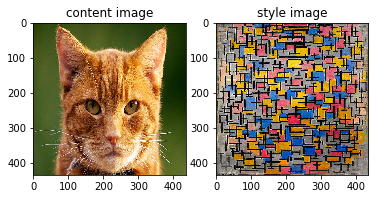

In [3]:
img_size = (435, 435)
content_image_path = './image/content_2.jpg'
style_image_path   = './image/style_1.png'

content = Image.open(content_image_path).resize(img_size)
style   = Image.open(style_image_path).resize(img_size)

plt.subplot(1, 2, 1)
plt.title('content image')
plt.imshow(content)
plt.subplot(1, 2, 2)
plt.title('style image')
plt.imshow(style)
print('image size: ', img_size)

In [4]:
def preprocess_image(img):
    """
    subtract mean image and convert RGB -> BGR
    """
    img = np.asarray(img, dtype=np.float32)
    img = img[:, :, :3]  # delete alpha channel
    img -= np.array([103.939, 116.779, 123.68])  # subtract mean image
    img = img.transpose((2, 0, 1))
    img = img[::-1]  # RGB -> BGR
    return img

def deprocess_image(x):
    x = x[0].transpose((1, 2, 0)) # (ch, h, w) -> (h, w, ch)
    x += np.array([103.939, 116.779, 123.68])
    x =  np.clip(x, 0, 255)
    x = x[:, :, ::-1] # BGR -> RGB
    return np.uint8(x)

content = preprocess_image(content)
style   = preprocess_image(style)

# Training by using Adam

## Define helper functions

In [14]:
def gram_matrix(feat):
    _, ch, w, h = feat.data.shape
    feat = F.reshape(feat, (ch, -1))
    gram = F.matmul(feat, feat, transb=True)
    return gram

def content_loss(mid_gen, mid_content, layers=['conv4_2']):
    L_content = 0
    for ln in layers:
        L_content += F.mean_squared_error(mid_gen[ln], Variable(mid_content[ln].data))
    return L_content

def style_loss(mid_gen, style_mats,
               layers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1'], w=0.2):
    L_style = 0
    for ln in layers:
        G = gram_matrix(mid_gen[ln])
        L_style += F.mean_squared_error(G, Variable(style_mats[ln].data))
    return w * L_style

def get_mid_and_stylemats(nn, content, style):
    mid_content = nn(Variable(np.array([content]), volatile=True))
    mid_style   = nn(Variable(np.array([style]), volatile=True))
    style_mats  = {ln: gram_matrix(mid_style[ln]) for ln in mid_style}
    return mid_content, style_mats

## Setup

In [17]:
vgg = VGG()

# mid_content = vgg(Variable(np.array([content]), volatile='on'))
# mid_style   = vgg(Variable(np.array([style]), volatile='on'))
# style_mats  = {ln: gram_matrix(mid_style[ln]) for ln in mid_style}

mid_content, style_mats = get_mid_and_stylemats(vgg, content, style)

init_img = np.random.uniform(0, 255, (img_size[0], img_size[1], 3)).astype(np.float32)
init_img = preprocess_image(init_img).reshape((1, 3, img_size[0], img_size[1]))
img_gen  = L.Parameter(init_img)

optimizer = optimizers.Adam()
optimizer.setup(img_gen)

load model... ./model/VGG_ILSVRC_16_layers.chainermodel.pkl


In [ ]:
from ipywidgets import FloatProgress
from IPython.display import display

alpha = 1.0e-3
beta  = 1.0
w = 0.2

n_epochs = 100

note_cycle = 500
save_cycle = 10

fp = FloatProgress(min=1, max=n_epochs)
display(fp)

for epoch in range(1, n_epochs + 1):
    img_gen.cleargrads()
    mid_gen = vgg(img_gen.W)
    
    L_content = content_loss(mid_gen, mid_content)
    L_style   = style_loss(mid_gen, style_mats)
    L_total   = alpha * L_content + beta * L_style
    
    L_total.backward()
    optimizer.update()

    if epoch % save_cycle == 0:
        tmp = deprocess_image(img_gen.W.data)
        Image.fromarray(tmp).save('./genearted/{}epoch.png'.format(epoch))
        print('save image')
    fp.value = epoch

# Training by using L-BFGS

In [6]:
class Evaluator:
    def __init__(self, nn, content, style, alpha=1.0e-3, beta=1.0):
        self.nn = nn
        self.alpha = alpha
        self.beta = beta
        
        self.loss_value = None
        self.grad_value = None
        
        self.mid_content, self.style_mats = get_mid_and_stylemats(self.nn, content, style)
    
    def loss(self, x):
        x = x.reshape((1, 3, img_size[0], img_size[1]))
        x = Variable(x.astype(np.float32))
        mid_gen = self.nn(x)
        L_content = content_loss(mid_gen, self.mid_content)
        L_style   = style_loss(mid_gen, self.style_mats)
        L_total   = self.alpha * L_content + self.beta * L_style
        
        L_total.backward()
        self.loss_value = L_total.data
        self.grad_value = x.grad
        return np.array([self.loss_value])
    
    def grad(self, x):
        return np.ravel(self.grad_value)

In [7]:
evaluator = Evaluator(VGG(), content, style)
init_img = np.random.uniform(-50, 50, size=(1, 3, img_size[0], img_size[1])).astype(np.float32)
init_img = np.ravel(init_img)

load model... ./model/VGG_ILSVRC_16_layers.chainermodel.pkl


In [ ]:
from scipy.optimize import fmin_l_bfgs_b

for i in range(10):
    print('iteration:', i)
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, init_img,
                                     fprime=evaluator.grad, maxfun=20)
    tmp = deprocess_image(min_val.reshape((1, 3, img_size[0], img_size[1])))
    Image.fromarray(tmp).save('./genearted/{}epoch.png'.format(i))